In [39]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

In [40]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

##Data generation

In [41]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p_data = 0.7 # prob of the first peak in data space
N = 10000 # amount of data
batch_size = 100
num_epoches = 250
z_dim = 2

In [42]:
c = torch.distributions.Bernoulli(p_data). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [43]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

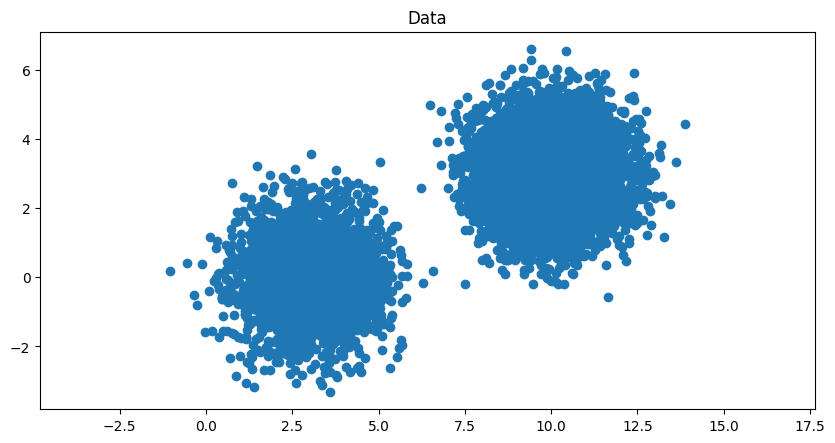

In [6]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Data')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [7]:
class VAE_MoG_prior(nn.Module):
    def __init__(self):
        super(VAE_MoG_prior, self).__init__()

        self.fc0 = nn.Linear(2, 5) # for encoder
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, z_dim) 
        self.fc3 = nn.Linear(10, z_dim)

        self.fc4 = nn.Linear(z_dim, 10) # for decoder
        self.fc5 = nn.Linear(10, 5)
        self.fc6 = nn.Linear(5, 2)
    
    def encode(self, x):
        h = torch.relu(self.fc0(x))
        g = torch.relu(self.fc1(h))
        return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.randn_like(std)
        return mu + eps * std
  
    def decode(self, z):
        h = torch.relu(self.fc4(z))
        g = torch.relu(self.fc5(h))
        return self.fc6(g) # mu_0 -- parameter of p_{theta}

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
model = VAE_MoG_prior().to(device)

In [9]:
p_prior = nn.Parameter(torch.tensor(0.5, device=device, dtype=torch.float32), requires_grad=False)

m_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
m_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

logvar_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
logvar_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

In [10]:
params = list(model.parameters()) + [p_prior, m_1, logvar_1, m_2, logvar_2]

In [11]:
optimizer = optim.Adam(params=params, lr=1e-3)

$L = KL - ELH = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - KL(q_{\phi}(z|x)||p(z))) = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - \mathbb{E}_{q_{\phi}(z|x)}(\log{q_{\phi}(z|x)} - \log{p(z)}))$

$\mathbb{E}_{q_{\phi}(z|x)}\log{q_{\phi}(z|x)} = \int q_{\phi}(z|x)\log{q_{\phi}(z|x)}dz = -\frac{J}{2}\log{2\pi} - \frac{1}{2}\sum_{j = 1}^{J}{(1+\log{\sigma_{j}^{2}})}$

In [12]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))

In [13]:
def loss_function(x, mu_0, mu, logvar, p_prior, m_1, m_2, logvar_1, logvar_2): # mu_0 -- mean of p_{theta}; mu, logvar -- parameters of q_{phi}, p, m_1, m_2, logvar_1, logvar_2 -- parameters of prior p(z)
    g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp())
    g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp())
    z_0 = mu + std_normal.sample(mu.shape) * (logvar * 0.5).exp() # reparametrization
    A = -0.5 * (1 + logvar)
    concat_tensor = torch.cat([(torch.log(p_prior) + g_1.log_prob(z_0))[None], (torch.log(1. - p_prior) + g_2.log_prob(z_0))[None]], dim=0)
    B = torch.logsumexp(concat_tensor, dim=0) #  1-MC approximation of E_{q_{phi}}[log p(z)]
    KL = A - B
    p_theta = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
    ELH = p_theta.log_prob(x) # 1-MC approximation of expected log-likelihood
    return KL.mean() - ELH.mean()

In [14]:
dataloader = DataLoader(Y[:, 0:2], batch_size = batch_size, shuffle = True)

In [15]:
for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar, p_prior, m_1, m_2, logvar_1, logvar_2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 50 == 0:
        print("loss =", loss.cpu().detach().numpy())

  0%|          | 1/250 [00:01<05:18,  1.28s/it]

loss = 23.10097


 20%|██        | 51/250 [01:00<03:54,  1.18s/it]

loss = 4.015725


 40%|████      | 101/250 [01:59<02:57,  1.19s/it]

loss = 4.0107093


 60%|██████    | 151/250 [02:58<01:56,  1.18s/it]

loss = 4.124693


 80%|████████  | 201/250 [03:57<00:57,  1.18s/it]

loss = 4.1295905


100%|██████████| 250/250 [04:55<00:00,  1.18s/it]


##Generation

In [16]:
bern = torch.distributions.Bernoulli(p_prior).sample((1000, )).view(-1, 1)
g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp()).sample((1000, ))
g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp()).sample((1000, ))

pr_samples = bern * g_1 + (1 - bern) * g_2 # get 1000 samples from trained prior

In [17]:
mu_post = model.decode(pr_samples).detach() # means of p_{theta}(x|z)

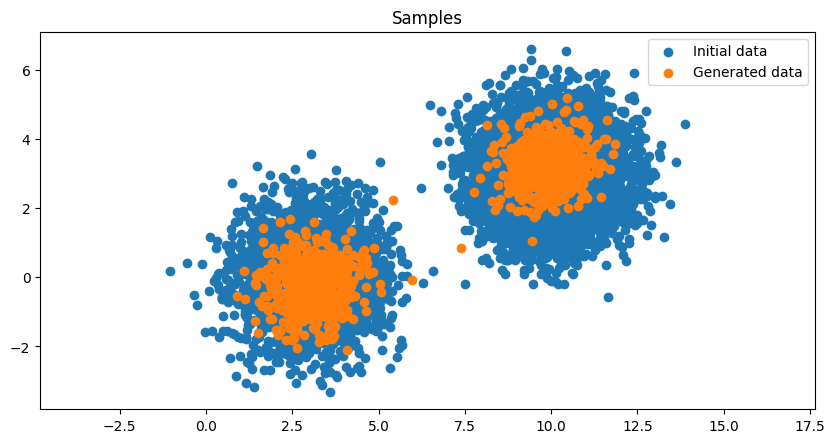

In [18]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(mu_post[:, 0].cpu(), mu_post[:, 1].cpu(), label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

In [19]:
print("Prior parameters:")
print("p_prior = ", p_prior.cpu().numpy())
print("m_1 =", m_1.detach().cpu().numpy(), "logvar_1 =", logvar_1.detach().cpu().numpy())
print("m_2 =", m_2.detach().cpu().numpy(), "logvar_2 =", logvar_2.detach().cpu().numpy())

Prior parameters:
p_prior =  0.5
m_1 = [3.6474404  0.62701994] logvar_1 = [-2.0086038  0.2622144]
m_2 = [-1.8780364  -0.27324024] logvar_2 = [0.10017609 0.2850106 ]


No handles with labels found to put in legend.


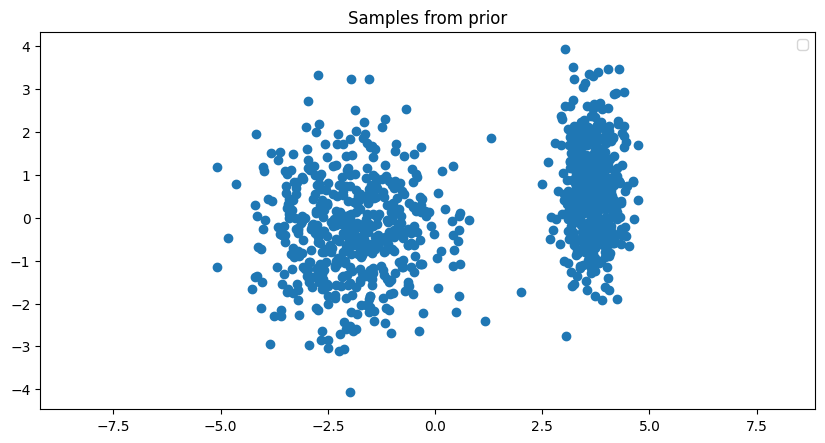

In [20]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [21]:
X_rec = model(X) # reconstructed data

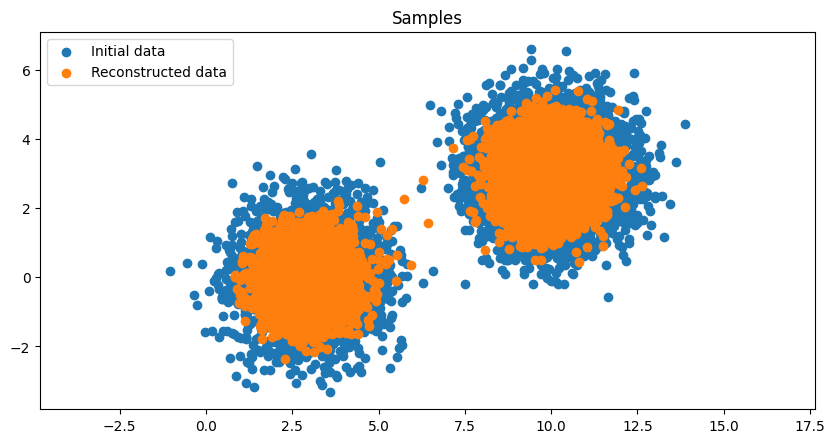

In [22]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

##Latent space vizualization

In [23]:
mu1_q, logvar1_q = model.encode(Y[Y[:, 2] == 0, 0:2])
mu2_q, logvar2_q = model.encode(Y[Y[:, 2] == 1, 0:2])

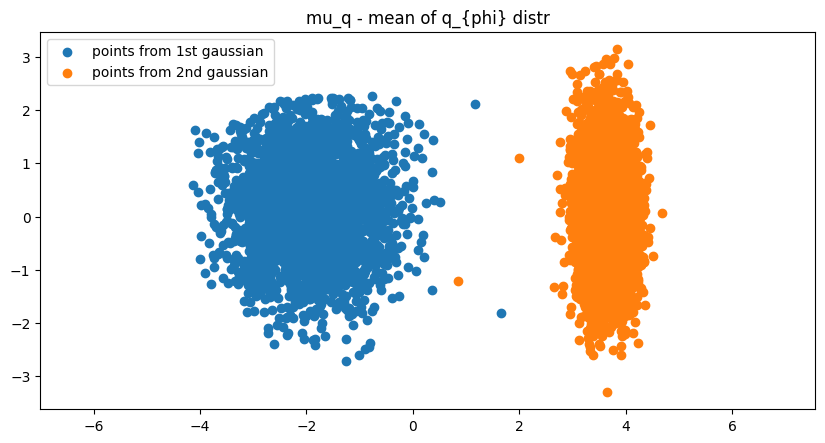

In [24]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu_q - mean of q_{phi} distr')
plt.scatter(mu1_q[:, 0].detach().cpu(), mu1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(mu2_q[:, 0].detach().cpu(), mu2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

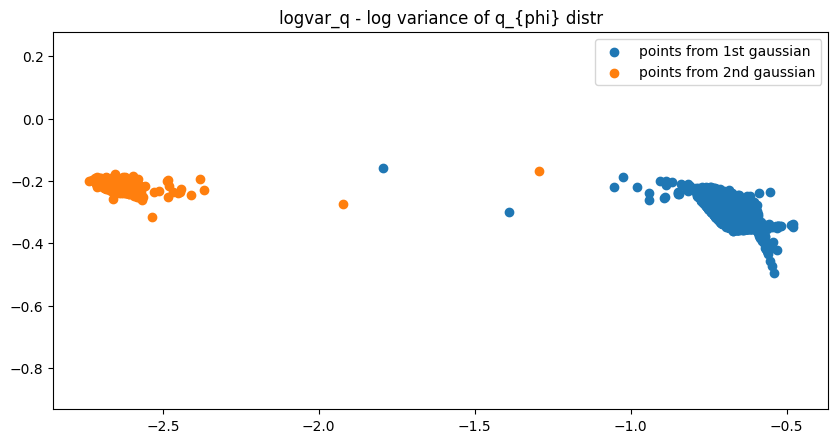

In [25]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar_q - log variance of q_{phi} distr')
plt.scatter(logvar1_q[:, 0].detach().cpu(), logvar1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(logvar2_q[:, 0].detach().cpu(), logvar2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

## Estimation of $\log{p_{\theta}(X)}$

In [51]:
N_IS = 1000
N_test = 2000

In [52]:
c_test = torch.distributions.Bernoulli(p_data). sample((N_test, )).to(device).view(-1, 1)
a_test = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N_test, ))
b_test = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N_test, ))

X_test = c_test * a_test + (1 - c_test) * b_test

In [53]:
def prior_log_prob(z, p_prior, m_1, logvar_1, m_2, logvar_2): # returns log p_{lambda}(z) for MoG prior
    g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp())
    g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp())
    concat_tensor = torch.cat([(torch.log(p_prior) + g_1.log_prob(z))[None], (torch.log(1. - p_prior) + g_2.log_prob(z))[None]], dim=0)
    return torch.logsumexp(concat_tensor, dim=0)

In [54]:
test_batch_size = 10
test_dataloader = DataLoader(X_test, batch_size=test_batch_size, shuffle=False, )

In [55]:
batch_mean = []
j = 0
with torch.no_grad():
    for batch in test_dataloader:
        res = torch.tensor([])
        for x in batch:
            mu_q, logvar_q = model.encode(x)
            q_phi = torch.distributions.Normal(loc=mu_q.detach(), scale=(0.5 * logvar_q.detach()).exp())
            Z = q_phi.sample((N_IS, ))
            m_0 = model.decode(Z) # means of p_theta
            p_theta = [torch.distributions.MultivariateNormal(loc=m_0[i].detach(), covariance_matrix=covar) for i in range(N_IS)]
            a = torch.tensor([p_theta[i].log_prob(x) for i in range(N_IS)]) # log p_{theta}(x|z_i)
            b = torch.tensor([prior_log_prob(Z[i], p_prior, m_1, logvar_1, m_2, logvar_2).sum() for i in range(N_IS)]) # log p(z_i)
            c = torch.tensor([q_phi.log_prob(Z[i]).sum() for i in range(N_IS)]) # log q_{phi}(z_i|x)
            res = torch.cat((res, (torch.logsumexp(a + b - c, dim=0) - torch.log(torch.tensor(N_IS, dtype=torch.float32))).view(-1)), dim=0)
        batch_mean.append(res.mean())
        if j % 10 == 0:
            print("batch #", j, "batch_mean =", res.mean())
        j += 1

batch # 0 batch_mean = tensor(-3.4034)
batch # 10 batch_mean = tensor(-3.2716)
batch # 20 batch_mean = tensor(-3.4261)
batch # 30 batch_mean = tensor(-3.3251)
batch # 40 batch_mean = tensor(-3.6722)
batch # 50 batch_mean = tensor(-3.6802)
batch # 60 batch_mean = tensor(-4.1015)
batch # 70 batch_mean = tensor(-3.5250)
batch # 80 batch_mean = tensor(-3.6595)
batch # 90 batch_mean = tensor(-3.8891)
batch # 100 batch_mean = tensor(-3.5085)
batch # 110 batch_mean = tensor(-3.2387)
batch # 120 batch_mean = tensor(-3.2634)
batch # 130 batch_mean = tensor(-3.5472)
batch # 140 batch_mean = tensor(-3.5917)
batch # 150 batch_mean = tensor(-3.3942)
batch # 160 batch_mean = tensor(-3.5943)
batch # 170 batch_mean = tensor(-3.8562)
batch # 180 batch_mean = tensor(-3.5262)
batch # 190 batch_mean = tensor(-3.6002)


In [56]:
print("mean =", torch.tensor(batch_mean).mean().numpy()) # mean of log p_{theta}(x)
print("std =", torch.tensor(batch_mean).std().numpy())

mean = -3.5816858
std = 0.19894652
